## Group 2 Scaling Experiment Notebook

In [9]:
import pyspark as ps
from pyspark.sql import SparkSession,SQLContext
from operator import add
from pyspark import SparkConf
import warnings
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
import time
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt

Below is a function that was defined to run spark and the analysis for a specific dataset and number of cores

In [2]:
def test(numCores,url):
    spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.6:7077") \
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","300s")\
        .config("spark.executor.cores",1)\
        .config("spark.cores.max", numCores)\
        .config("spark.driver.port",9998)\
        .config("spark.blockManager.port",10005)\
        .appName("Group2")\
        .getOrCreate()
    sc = spark_session.sparkContext
    spark = SparkSession(sc)
    df = spark.read.json(url)
    df.select("controversiality").distinct().collect()
    df_1 = df.select("body","controversiality")
    (train_set, val_set, test_set) = df_1.randomSplit([0.98, 0.01, 0.01], seed = 2000)
    tokenizer = Tokenizer(inputCol="body", outputCol="words")
    hashtf = HashingTF(numFeatures=2**12, inputCol="words", outputCol='tf')
    idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) 
    label_stringIdx = StringIndexer(inputCol = "controversiality", outputCol = "label")
    pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx])

    pipelineFit = pipeline.fit(train_set)
    train_df = pipelineFit.transform(train_set)
    val_df = pipelineFit.transform(val_set)

    start = time.time()
    lr = LogisticRegression(maxIter=100)
    lrModel = lr.fit(train_df)
    end = time.time()

    predictions = lrModel.transform(val_df)
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
    #evaluator.evaluate(predictions)
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
    spark.stop()
    return (print("time taken for training:{}".format(end-start)),accuracy)

### Strong Scaling Experiment 

In [11]:
test(1,"hdfs://192.168.2.6:9000/user/ubuntu/input/RC_2020-01-18")

22/03/25 10:40:37 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/03/25 10:40:37 WARN Utils: Service 'sparkDriver' could not bind on port 9998. Attempting port 9999.
22/03/25 10:40:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/03/25 10:40:37 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 10005. Attempting port 10006.
22/03/25 10:40:37 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


time taken for training:1029.1486976146698


(None, 0.9811204098306358)

In [12]:
test(2,"hdfs://192.168.2.6:9000/user/ubuntu/input/RC_2020-01-18")

22/03/25 11:07:49 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/03/25 11:07:49 WARN Utils: Service 'sparkDriver' could not bind on port 9998. Attempting port 9999.
22/03/25 11:07:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/03/25 11:07:49 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 10005. Attempting port 10006.
22/03/25 11:07:49 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


time taken for training:481.26484751701355


(None, 0.9811204098306358)

In [13]:
test(3,"hdfs://192.168.2.6:9000/user/ubuntu/input/RC_2020-01-18")

22/03/25 11:21:13 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/03/25 11:21:13 WARN Utils: Service 'sparkDriver' could not bind on port 9998. Attempting port 9999.
22/03/25 11:21:13 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/03/25 11:21:13 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 10005. Attempting port 10006.
22/03/25 11:21:13 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


time taken for training:315.02403807640076


(None, 0.9811204098306358)

In [14]:
test(4,"hdfs://192.168.2.6:9000/user/ubuntu/input/RC_2020-01-18")

22/03/25 11:34:41 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/03/25 11:34:41 WARN Utils: Service 'sparkDriver' could not bind on port 9998. Attempting port 9999.
22/03/25 11:34:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/03/25 11:34:41 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 10005. Attempting port 10006.
22/03/25 11:34:41 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


time taken for training:246.72914171218872


(None, 0.9811204098306358)

In [15]:
# Time results from training for 1,2,3,4 varying cores
one = 1029
two = 481
three = 315
four = 247

<Figure size 432x288 with 0 Axes>

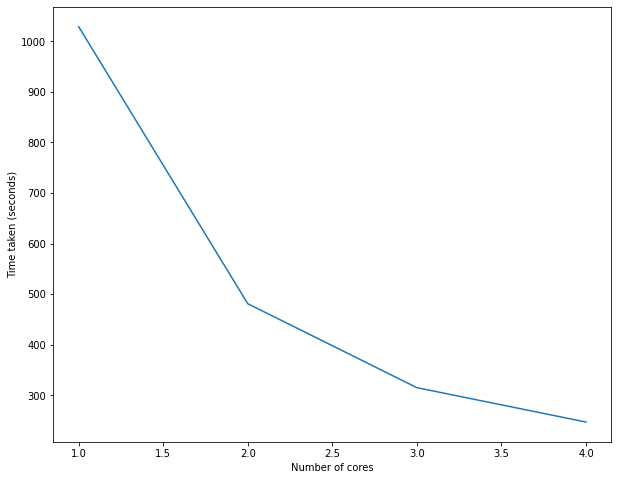

In [16]:
#Weak Scaling Plot
fig = plt.figure()
x = [1,2,3,4]
y = [one,two,three,four]
plt.figure(figsize=(10, 8))
plt.plot(x,y)

plt.xlabel("Number of cores")
plt.ylabel("Time taken (seconds)")
plt.savefig("strong_scaling.png")

### Weak Scaling Experiment

In [6]:
test(1,"hdfs://192.168.2.6:9000/user/ubuntu/input/RC_2005-12")

22/03/25 10:36:59 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/03/25 10:36:59 WARN Utils: Service 'sparkDriver' could not bind on port 9998. Attempting port 9999.
22/03/25 10:36:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/03/25 10:36:59 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 10005. Attempting port 10006.
22/03/25 10:36:59 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


time taken for training:5.181334018707275


(None, 0.6923076923076923)

In [4]:
test(2,"hdfs://192.168.2.6:9000/user/ubuntu/input/RC_2007-07")

22/03/25 10:28:14 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/03/25 10:28:14 WARN Utils: Service 'sparkDriver' could not bind on port 9998. Attempting port 9999.
22/03/25 10:28:14 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/03/25 10:28:14 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 10005. Attempting port 10006.
22/03/25 10:28:14 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.
22/03/25 10:29:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/03/25 10:29:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/03/25 10:29:01 WARN BLAS: Failed to load implementation from: com.github.fommil

time taken for training:30.312164306640625


(None, 0.9425981873111783)

In [3]:
test(3,"hdfs://192.168.2.6:9000/user/ubuntu/input/RC_2010-02")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/25 10:23:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/03/25 10:23:56 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/03/25 10:23:57 WARN Utils: Service 'sparkDriver' could not bind on port 9998. Attempting port 9999.
22/03/25 10:23:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/03/25 10:23:58 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 10005. Attempting port 10006.
22/03/25 10:23:58 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is 

time taken for training:68.8427414894104


(None, 1.0)

In [5]:
test(4,"hdfs://192.168.2.6:9000/user/ubuntu/input/RC_2020-01-18")

22/03/25 10:29:17 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/03/25 10:29:17 WARN Utils: Service 'sparkDriver' could not bind on port 9998. Attempting port 9999.
22/03/25 10:29:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/03/25 10:29:17 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 10005. Attempting port 10006.
22/03/25 10:29:17 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.
22/03/25 10:30:10 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


time taken for training:240.03434467315674


(None, 0.9811204098306358)

In [7]:
# Time results from training for 1,2,3,4 varying cores and varying dataset size
one_w = 5
two_w = 30
three_w = 69
four_w = 240

<Figure size 432x288 with 0 Axes>

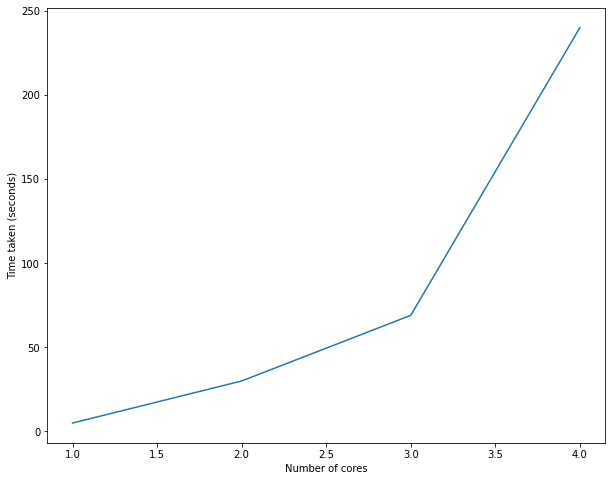

In [10]:
#Weak Scaling Plot
fig = plt.figure()
x = [1,2,3,4]
y = [one_w,two_w,three_w,four_w]
plt.figure(figsize=(10, 8))
plt.plot(x,y)

plt.xlabel("Number of cores")
plt.ylabel("Time taken (seconds)")
plt.savefig("weak_scaling.png")